# Project 1

Aleksandra Krasicka 148254

Małgorzata Gierdewicz 148264

## Data creation

For each class, there is one pattern occurring in the data. Solving just a classification task be scored no higher than 70%.

Please provide either pdf with the report or add some notes in the notebook. Demonstrate some examples of how your approach works.

A short reminder of your task:
 - Correct classification of provided time series
 - Explanation of the prediction
 - Neural network with at least one recurrent layer must be used in each step
 - Not the whole logic must be inside the neural network
 - Your approach should work for other data, of course after retraining. It means you shouldn't take advantage of knowing the series are based on sin function and how the anomalies are created.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.layers import SimpleRNN, Dense, Masking, Embedding, TimeDistributed
from keras.models import Sequential, load_model
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import SimpleRNN, Dense, Masking, Embedding, TimeDistributed
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, precision_score, recall_score

In [2]:
np.random.seed(42)

In [3]:
n = 50000

In [4]:
def createRow(n, classes):
    base = np.sin(np.linspace((np.random.rand(3)),(np.random.rand(3) + np.array([10,15,7])),n))
    if classes[0] > 0:
        base[np.random.randint(0,n), 0] += 2
    if classes[1] > 0:
        base[np.random.randint(0,n), 1] -= 2
    if classes[2] > 0:
        x = np.random.randint(0,n-5)
        base[x:x+4,2] = 0
    if classes[3] > 0:
        x = np.random.randint(0,n-10)
        base[x:x+8,1] += 1.5
    if classes[4] > 0:
        x = np.random.randint(0,n-7)
        base[x:x+6,0] += 1.5
        base[x:x+6,2] -= 1.5
    base += np.random.rand(*base.shape)*.2
    return base

In [5]:
xl, yl = [], []
for _ in range(n):
    cl = np.random.rand(5)<.25
    xl.append(createRow(np.random.randint(40,60), cl))
    yl.append(cl)


[False False False False  True]


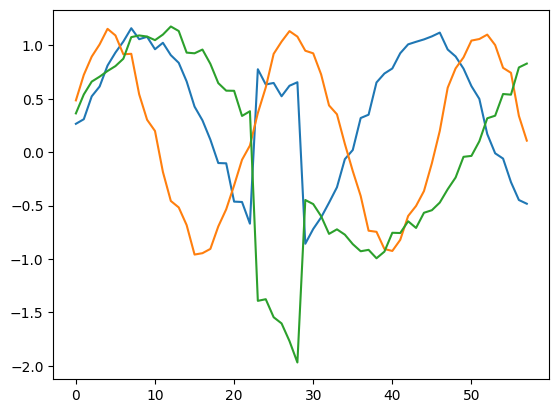

[False False False  True  True]


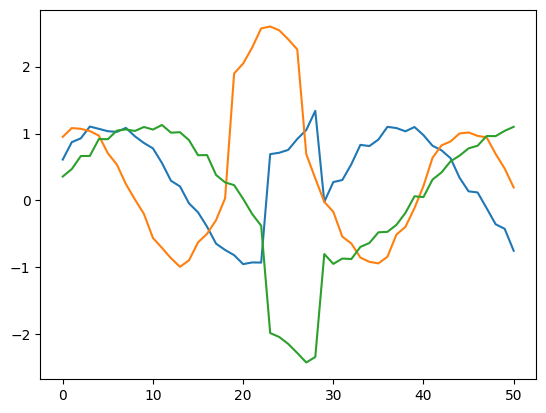

[False False False False False]


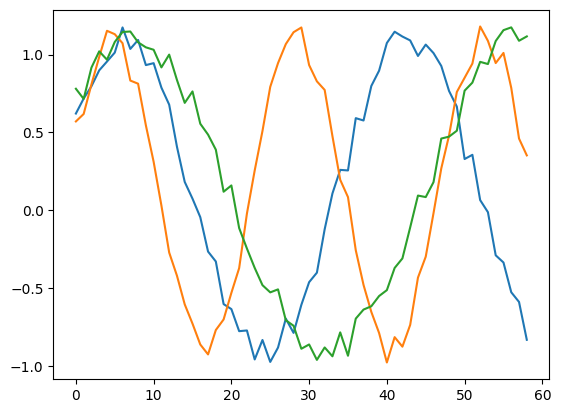

[ True False False False  True]


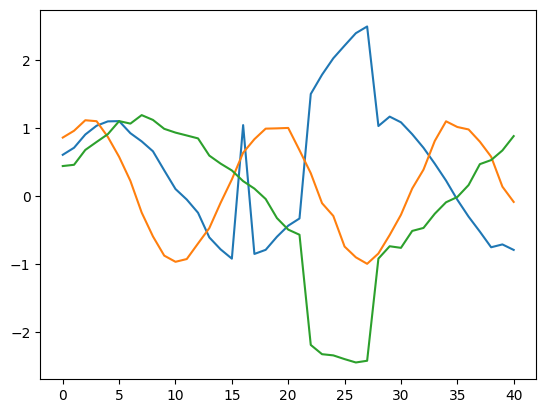

[False  True False False False]


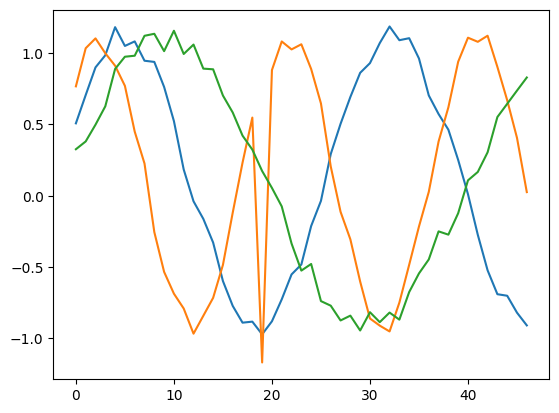

In [6]:
for i in range(5):
    plt.plot(xl[i])
    print(yl[i])
    plt.show()

## Dataset

Table xl:
* each line is a differen step of production
* each step is desribed by 3 values each from different sensor
* the number of steps for each candie differes (from 40 to 60) but the yl for them is always 5

Table yl:
* each line has 5 values True or False being equivalent to 5 defects (if they have them of not)



In [7]:
print(len(xl[0]), len(xl[1]))

58 51


In [8]:
print(len(yl[0]), len(yl[1]))

5 5


In [9]:
y_df = pd.DataFrame(yl)

Let's add info if given candy is defected (predicting that can be easier then all at the beggining)

In [10]:
y_df['Defective'] = y_df.any(axis=1)

In [11]:
y_df.head()

,0,1,2,3,4,Defective
0,False,False,False,False,True,True
1,False,False,False,True,True,True
2,False,False,False,False,False,False
3,True,False,False,False,True,True
4,False,True,False,False,False,True


In [12]:
y_df_apply = y_df.apply(lambda x: x.apply(lambda y: 1 if y else 0))

In [13]:
y_df_apply.head()

,0,1,2,3,4,Defective
0,0,0,0,0,1,1
1,0,0,0,1,1,1
2,0,0,0,0,0,0
3,1,0,0,0,1,1
4,0,1,0,0,0,1


In [14]:
len(y_df[y_df['Defective']==True])

38277

In [15]:
len(y_df[y_df['Defective']==False])

11723

We can see that there is almost 3 times as many defected candies as the correct ones. Let's look how it looks for the other columns.

In [16]:
for i in range(5):
  print("Column: ",i,"\nTrue: ", len(y_df[y_df[i]==True]), "\nFalse: ", len(y_df[y_df[i]==False]))

Column:  0 
True:  12584 
False:  37416
Column:  1 
True:  12390 
False:  37610
Column:  2 
True:  12537 
False:  37463
Column:  3 
True:  12652 
False:  37348
Column:  4 
True:  12542 
False:  37458


In [17]:
min_len = len(xl[0])
max_len = len(xl[0])
for i in range(len(xl)):
  min_len = min(min_len, len(xl[i]))
  max_len = max(max_len, len(xl[i]))

In [18]:
print("Min len: ", min_len, "\nMax_len: ", max_len)

Min len:  40 
Max_len:  59


We don't like that it is not always 59 so we will change it
(https://goodboychan.github.io/python/deep_learning/tensorflow-keras/2020/12/09/01-RNN-Many-to-many.html)

In [19]:
xl_padded = tf.keras.preprocessing.sequence.pad_sequences(xl, padding='post', dtype='float32')

In [20]:
min_len = len(xl_padded[0])
max_len = len(xl_padded[0])
for i in range(len(xl_padded)):
  min_len = min(min_len, len(xl_padded[i]))
  max_len = max(max_len, len(xl_padded[i]))

In [21]:
print("Min len: ", min_len, "\nMax_len: ", max_len)

Min len:  59 
Max_len:  59


Now it's much better

## SimpleRNN - model

Let's get the size of our X and Y for the model (needed in many-to-many)

X:

In [ ]:
print(n)

In [ ]:
np.shape(xl_padded)

In [ ]:
print(max_len)

In [ ]:
num_features = len(xl_padded[0][0])
print(num_features)

Y:

In [ ]:
print(len(yl)) # same as n

50000


In [ ]:
np.shape(yl)

(50000, 5, 2)

In [ ]:
num_defects = len(yl[0])
print(num_defects)

5


In [ ]:
print(yl[:3])

[[[1. 0.]
  [1. 0.]
  [1. 0.]
  [1. 0.]
  [0. 1.]]

 [[1. 0.]
  [1. 0.]
  [1. 0.]
  [0. 1.]
  [0. 1.]]

 [[1. 0.]
  [1. 0.]
  [1. 0.]
  [1. 0.]
  [1. 0.]]]


### Split into train and test

In [ ]:
xl_train, xl_test, yl_train, yl_test = train_test_split(xl_padded, yl, test_size=0.2, random_state=42)
xl_train = np.asarray(xl_train)
yl_train = np.asarray(yl_train)

In [ ]:
xl_test = np.asarray(xl_test)
yl_test = np.asarray(yl_test)

In [ ]:
np.shape(yl_train)

(30000, 5)

In [ ]:
np.shape(yl_test)

(20000, 5)

### Model

The first model we implement is a simple RNN model. We set the imput shape according to dimentions obtained in the previous sections.

In [ ]:
model = Sequential()
model.add(Masking(mask_value=0.0, input_shape=(max_len, num_features)))
model.add(SimpleRNN(units=32, activation='relu'))
model.add(Dense(units=num_defects, activation='sigmoid'))

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_3 (Masking)         (None, 59, 3)             0         
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 32)                1152      
                                                                 
 dense_3 (Dense)             (None, 5)                 165       
                                                                 
Total params: 1317 (5.14 KB)
Trainable params: 1317 (5.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.fit(xl_train, yl_train, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100
750/750 [==============================] - 10s 11ms/step - loss: 0.4716 - accuracy: 0.2562 - val_loss: 0.3997 - val_accuracy: 0.3723
Epoch 2/100
750/750 [==============================] - 9s 13ms/step - loss: 0.3926 - accuracy: 0.3473 - val_loss: 0.3737 - val_accuracy: 0.3197
Epoch 3/100
750/750 [==============================] - 10s 13ms/step - loss: 0.3939 - accuracy: 0.3637 - val_loss: 0.3739 - val_accuracy: 0.4015
Epoch 4/100
750/750 [==============================] - 8s 11ms/step - loss: 0.3701 - accuracy: 0.4061 - val_loss: 0.3587 - val_accuracy: 0.4415
Epoch 5/100
750/750 [==============================] - 10s 13ms/step - loss: 0.3608 - accuracy: 0.4282 - val_loss: 0.3489 - val_accuracy: 0.4675
Epoch 6/100
750/750 [==============================] - 9s 12ms/step - loss: 0.3943 - accuracy: 0.4264 - val_loss: 0.3997 - val_accuracy: 0.4613
Epoch 7/100
750/750 [==============================] - 8s 11ms/step - loss: 0.3589 - accuracy: 0.4395 - val_loss: 0.3606 - val_accura

### Accuracy

The accuracy for epoch 10 was about 80% so we increased it and also changed the batch size and currently the best we got was 94%.

In [ ]:
predictions = model.predict(xl_test)

# Round the predictions to obtain binary values (0 or 1)
rounded_predictions = np.round(predictions)

# Evaluate the accuracy
accuracy = np.mean(rounded_predictions == yl_test)
print("Test Accuracy:", accuracy)

625/625 [==============================] - 6s 9ms/step
Test Accuracy: 0.84744


In [ ]:
print(predictions[:5])

[[2.1350030e-03 4.5900766e-04 2.6270518e-01 2.1095498e-01 2.2280358e-01]
 [1.8119611e-03 1.4925794e-03 2.6784089e-01 2.0498668e-01 2.3516010e-01]
 [4.2787101e-03 1.8554466e-03 2.6354331e-01 2.4008858e-01 2.3957638e-01]
 [6.1374148e-03 9.9902809e-01 2.6582882e-01 3.1557000e-01 2.5039947e-01]
 [4.8081214e-03 1.9441684e-03 2.5976998e-01 2.2743830e-01 2.3713998e-01]]


In [ ]:
print(rounded_predictions[:5])

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


In [ ]:
print(yl_test[:5])

[[False False  True False False]
 [False False False False False]
 [False False  True False  True]
 [False  True  True  True False]
 [False False False False False]]


In [ ]:
model.save('simpleRNN_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## LSTM - model

We decided to try some more complicated RNN structures and used LSTM and GRU (next section) according to tutorial showned here: https://www.kaggle.com/code/thebrownviking20/intro-to-recurrent-neural-networks-lstm-gru

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error



```
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(max_len, num_features)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(2, activation='softmax'))

# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
# regressor.fit(X_train,y_train,epochs=50,batch_size=32)
```



In [ ]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(max_len, num_features), activation='relu'))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=False))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(5, activation='softmax'))

# Compiling the RNN
regressor.compile(optimizer='adam',loss='mean_squared_error')
# Fitting to the training set
# regressor.fit(X_train,y_train,epochs=50,batch_size=32)

In [ ]:
regressor.fit(xl_train, yl_train, epochs=25, batch_size=32, validation_split=0.2)

Epoch 1/25
1000/1000 [==============================] - 61s 58ms/step - loss: 0.1334 - val_loss: 0.1125
Epoch 2/25
1000/1000 [==============================] - 55s 55ms/step - loss: 0.1163 - val_loss: 0.0994
Epoch 3/25
1000/1000 [==============================] - 54s 54ms/step - loss: 0.1017 - val_loss: 0.0965
Epoch 4/25
1000/1000 [==============================] - 54s 54ms/step - loss: 0.0959 - val_loss: 0.0915
Epoch 5/25
1000/1000 [==============================] - 54s 54ms/step - loss: 0.0986 - val_loss: 0.1020
Epoch 6/25
1000/1000 [==============================] - 54s 54ms/step - loss: 0.1183 - val_loss: 0.0979
Epoch 7/25
1000/1000 [==============================] - 55s 55ms/step - loss: 0.0963 - val_loss: 0.0908
Epoch 8/25
1000/1000 [==============================] - 54s 54ms/step - loss: 0.0923 - val_loss: 0.0889
Epoch 9/25
1000/1000 [==============================] - 54s 54ms/step - loss: 0.0957 - val_loss: 0.0872
Epoch 10/25
1000/1000 [==============================] - 54s 54m

### Accuracy

In [ ]:
predictions_regressor = regressor.predict(xl_test)

# Round the predictions to obtain binary values (0 or 1)
rounded_predictions_regressor = np.round(predictions_regressor)

# Evaluate the accuracy
accuracy = np.mean(rounded_predictions_regressor == yl_test)
print("Test Accuracy:", accuracy)

313/313 [==============================] - 6s 17ms/step
Test Accuracy: 0.88346


the accuracy is 88%

## GRU - model

In [ ]:
# The GRU architecture
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(max_len, num_features), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(max_len, num_features), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(max_len, num_features), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))

In [ ]:
# Compiling the RNN
regressorGRU.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9, nesterov=False),loss='mean_squared_error')

In [ ]:
# Fitting to the training set
regressorGRU.fit(xl_train,yl_train,epochs=100,batch_size=150)

Epoch 1/100
267/267 [==============================] - 65s 217ms/step - loss: 0.1893
Epoch 2/100
267/267 [==============================] - 59s 219ms/step - loss: 0.1879
Epoch 3/100
267/267 [==============================] - 58s 215ms/step - loss: 0.1878
Epoch 4/100
267/267 [==============================] - 57s 215ms/step - loss: 0.1878
Epoch 5/100
267/267 [==============================] - 59s 219ms/step - loss: 0.1877
Epoch 6/100
267/267 [==============================] - 59s 222ms/step - loss: 0.1876
Epoch 7/100
267/267 [==============================] - 57s 215ms/step - loss: 0.1876
Epoch 8/100
267/267 [==============================] - 59s 220ms/step - loss: 0.1875
Epoch 9/100
267/267 [==============================] - 57s 215ms/step - loss: 0.1875
Epoch 10/100
267/267 [==============================] - 57s 215ms/step - loss: 0.1875
Epoch 11/100
267/267 [==============================] - 59s 221ms/step - loss: 0.1874
Epoch 12/100
267/267 [==============================] - 58s 217

### Accuracy

In [ ]:
predictions_regressorGRU = regressorGRU.predict(xl_test)

# Round the predictions to obtain binary values (0 or 1)
rounded_predictions_regressorGRU = np.round(predictions_regressorGRU)

# Evaluate the accuracy
accuracy = np.mean(rounded_predictions_regressorGRU == yl_test)
print("Test Accuracy:", accuracy)

313/313 [==============================] - 10s 29ms/step
Test Accuracy: 0.76666


the accuracy is 76.7%

## GRU - other approach

In [ ]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import LearningRateScheduler

### Learning Rate Scheduler

In [ ]:
def lr_schedule(epoch):
    return 0.01 * 0.9**epoch

In [ ]:
lr_scheduler = LearningRateScheduler(lr_schedule)

### Early Stopping

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

### Model

In [ ]:
print(xl_train.shape, yl_train.shape)
print(xl_test.shape, yl_test.shape)


(40000, 59, 3) (40000, 5)
(10000, 59, 3) (10000, 5)


In [ ]:
# The GRU architecture
regressorGRU2 = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU2.add(GRU(units=50, return_sequences=True, input_shape=(max_len, num_features), activation='tanh'))
regressorGRU2.add(Dropout(0.2))
# Second GRU layer
regressorGRU2.add(GRU(units=50, return_sequences=True, input_shape=(max_len, num_features), activation='tanh'))
regressorGRU2.add(Dropout(0.2))
# Third GRU layer
regressorGRU2.add(GRU(units=50, return_sequences=True, input_shape=(max_len, num_features), activation='tanh'))
regressorGRU2.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU2.add(GRU(units=50, activation='tanh'))
regressorGRU2.add(Dropout(0.2))
# The output layer
regressorGRU2.add(Dense(units=1))

# Compiling the RNN
regressorGRU2.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9, nesterov=False),loss='mean_squared_error')

# Fitting to the training set
xl_train, xl_val, yl_train, yl_val = train_test_split(xl_train, yl_train, test_size=0.2, random_state=42)

regressorGRU2.fit(xl_train, yl_train, epochs=100, batch_size=32, validation_data=(xl_val, yl_val), callbacks=[lr_scheduler, early_stopping])

Epoch 1/100
1000/1000 [==============================] - 102s 96ms/step - loss: 0.1893 - val_loss: 0.1862 - lr: 0.0100
Epoch 2/100
1000/1000 [==============================] - 98s 98ms/step - loss: 0.1885 - val_loss: 0.1867 - lr: 0.0090
Epoch 3/100
1000/1000 [==============================] - 93s 93ms/step - loss: 0.1883 - val_loss: 0.1863 - lr: 0.0081
Epoch 4/100
1000/1000 [==============================] - 93s 93ms/step - loss: 0.1881 - val_loss: 0.1865 - lr: 0.0073
Epoch 5/100
1000/1000 [==============================] - 93s 93ms/step - loss: 0.1880 - val_loss: 0.1859 - lr: 0.0066
Epoch 6/100
1000/1000 [==============================] - 97s 97ms/step - loss: 0.1880 - val_loss: 0.1859 - lr: 0.0059
Epoch 7/100
1000/1000 [==============================] - 94s 94ms/step - loss: 0.1879 - val_loss: 0.1858 - lr: 0.0053
Epoch 8/100
1000/1000 [==============================] - 95s 95ms/step - loss: 0.1878 - val_loss: 0.1861 - lr: 0.0048
Epoch 9/100
1000/1000 [==============================] 

### Accuracy

In [ ]:
predictions_regressorGRU2 = regressorGRU2.predict(xl_test)

# Round the predictions to obtain binary values (0 or 1)
rounded_predictions_regressorGRU2 = np.round(predictions_regressorGRU2)

# Evaluate the accuracy
accuracy = np.mean(rounded_predictions_regressorGRU2 == yl_test)
print("Test Accuracy:", accuracy)

313/313 [==============================] - 13s 32ms/step
Test Accuracy: 0.74724


In [ ]:
regressorGRU2.save('GRU2_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Well... it didn't help... the accuracy is 75%. We will stick with the
SimpleRNN.

## LSTM - paramiter search

In [ ]:
!pip install scikeras

In [ ]:
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.optimizers import Adam, SGD


In [ ]:
def create_lstm_model(batch_size=50, activation='tanh', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(units=batch_size, return_sequences=True, input_shape=(max_len, num_features)))
    regressor.add(Dropout(0.2))
    # Second LSTM layer
    regressor.add(LSTM(units=batch_size, return_sequences=False))
    regressor.add(Dropout(0.2))
    # The output layer
    regressor.add(Dense(5, activation=activation))

    # if optimizer == 'adam':
    #     optimizer = Adam(learning_rate=learning_rate)
    # elif optimizer == 'sgd':
    #     optimizer = SGD(learning_rate=learning_rate, momentum=0.9, nesterov=False)

    model.compile(optimizer=optimizer, loss='mean_squared_error')

    return model

In [ ]:
param_grid = {
    'batch_size': [10, 20, 40, 60, 80, 100],
    'epochs': [5, 10, 15, 25, 50, 100],
    # 'activation': ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoig', 'hard_sigmoid', 'linear'],
    'optimizer': ['adam', 'sgd', 'rmsprop', 'adamw', 'adadelta', 'adamax', 'adafactor', 'nadam', 'ftrl']
}

In [ ]:
keras_regressor = KerasRegressor(build_fn=create_lstm_model, epochs=50, batch_size=32, verbose=0)

print(keras_regressor.get_params().keys())

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=keras_regressor, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)

# Fit the model to the data
grid_search_result = grid_search.fit(xl_train, yl_train)

# Print the best hyperparameters and corresponding score
print("Best Parameters: ", grid_search_result.best_params_)
print("Best Score: ", -grid_search_result.best_score_)

dict_keys(['model', 'build_fn', 'warm_start', 'random_state', 'optimizer', 'loss', 'metrics', 'batch_size', 'validation_batch_size', 'verbose', 'callbacks', 'validation_split', 'shuffle', 'run_eagerly', 'epochs'])


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 73, in _cached

# Root Cause Analysis (RCA)


We based our RCA on the article linked below. We had trubles with it but this article helped. It also caused some confusion because it uses sigmoid as the final activation function which works for the example in the article since the values there are between 0-1 and our are -1 - 1. Thanks to changing the activation function we managed to make it work and also learned that the sigmoid squiushes the values into 0-1 range which will be very helpfull for us in the future.

https://www.analyticsvidhya.com/blog/2022/01/complete-guide-to-anomaly-detection-with-autoencoders-using-tensorflow/

In [40]:
y_df['Defective'] = y_df.any(axis=1)
selected_rows = y_df['Defective'] != 1
x_good = xl_padded[selected_rows]
y_df_good = y_df[selected_rows]

y_df_good = y_df_good.drop('Defective', axis=1)

xl_train_good, xl_test_good, yl_train_good, yl_test_good = train_test_split(x_good, y_df_good, test_size=0.2, random_state=42)
xl_train_good = np.asarray(xl_train_good)
yl_train_good = np.asarray(yl_train_good)
xl_test_good = np.asarray(xl_test_good)
yl_test_good = np.asarray(yl_test_good)

In [41]:
xl_train_good_reshaped = xl_train_good.reshape((xl_train_good.shape[0], -1))
xl_test_good_reshaped = xl_test_good.reshape((xl_test_good.shape[0], -1))
print(np.shape(xl_train_good_reshaped))
print(np.shape(xl_test_good_reshaped))


(9378, 177)
(2345, 177)


In [42]:
autoencoder = Sequential()
#autoencoder.add(Masking(mask_value=0.0, input_shape=(max_len, num_features)))
autoencoder.add(tf.keras.layers.Dense(64, activation="relu"))
autoencoder.add(tf.keras.layers.Dense(32, activation="relu"))
autoencoder.add(tf.keras.layers.Dense(16, activation="relu"))
autoencoder.add(tf.keras.layers.Dense(8, activation="relu"))
autoencoder.add(tf.keras.layers.Dense(16, activation="relu"))
autoencoder.add(tf.keras.layers.Dense(32, activation="relu"))
autoencoder.add(tf.keras.layers.Dense(64, activation="relu"))
autoencoder.add(tf.keras.layers.Dense(177, activation="linear"))

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, mode="min")
autoencoder.compile(optimizer='adam', loss="mae")
history = autoencoder.fit(xl_train_good_reshaped, xl_train_good_reshaped, epochs=50, batch_size=120,
                    validation_data=(xl_test_good_reshaped, xl_test_good_reshaped),
                    shuffle=True,
                    callbacks=[early_stopping]
                    )

Epoch 1/50
79/79 [==============================] - 59s 8ms/step - loss: 0.3491 - val_loss: 0.2055
Epoch 2/50
79/79 [==============================] - 0s 5ms/step - loss: 0.1553 - val_loss: 0.1288
Epoch 3/50
79/79 [==============================] - 0s 4ms/step - loss: 0.1230 - val_loss: 0.1195
Epoch 4/50
79/79 [==============================] - 0s 4ms/step - loss: 0.1176 - val_loss: 0.1165
Epoch 5/50
79/79 [==============================] - 0s 5ms/step - loss: 0.1154 - val_loss: 0.1154
Epoch 6/50
79/79 [==============================] - 0s 5ms/step - loss: 0.1138 - val_loss: 0.1129
Epoch 7/50
79/79 [==============================] - 0s 6ms/step - loss: 0.1110 - val_loss: 0.1097
Epoch 8/50
79/79 [==============================] - 0s 5ms/step - loss: 0.1080 - val_loss: 0.1074
Epoch 9/50
79/79 [==============================] - 1s 7ms/step - loss: 0.1056 - val_loss: 0.1048
Epoch 10/50
79/79 [==============================] - 1s 11ms/step - loss: 0.1034 - val_loss: 0.1029
Epoch 11/50
79/79

In [43]:
x_predict = autoencoder.predict(xl_test_good_reshaped)

74/74 [==============================] - 0s 2ms/step


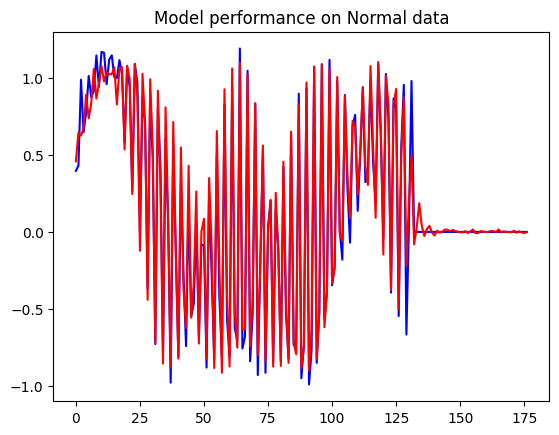

In [45]:
plt.plot(xl_test_good_reshaped[0], 'b')
plt.plot(x_predict[0], 'r')
plt.title("Model performance on Normal data")
plt.show()

I hope this pretty plot will make up for the delay in sending this project, which we are ***SINCERELY SORRY FOR***.